## Physics based parameter extraction

- Underwater Image formation model
    
    $$
    I_{c,i} = J_{c,i}*t_{c,i} + B_c^{\infty}(1-t_{c,i}) \\ t_{c,i} = e^{-\beta_c\mathbf{z}_i}
    $$
    
    - $I_c \in \real^{HW}$, represents the underwater image, subscript c denotes the index of the color channel {R,G,B}
    - $J_c$ is the original in-air image.
    - $t_{c,i}$ is the medium transmission rate
    - $\beta_c$ is the beam attenuation coefficient.
    - $\mathbf{z}_i$ is the depth
    - $B_c^\infty$ is the coefficient of ambient light causing the backscattering from the particles in water.
    
    $\beta, B$ vary depending on different water env and can be estimated using the depth estimation.
    
    - The relationship between metric depth $z_i$ and $d_i$, s and it are unknown coefficients.
    
    $$
    z_i = \frac{1}{sd_i+t}
    $$
    
    ## Parameter Estimation
    
    use parent model to correct the biased estimation of the model for more distant regions using extracted physics information from depth estimation for closer regions. 
    
    > **Require:** $d^D \in \mathbb{R}^{HW}, I_c \in \mathbb{R}^{HW}, N \in \mathbb{Z}_{++}, c \in \{G,B\}$
    **Ensure**: Pure background exists in the training images.
    1. Find farthest 15% points using $d^D$, denoted as $P^f$.
    2. Select the darkest 20% points using $I_c$ from $P^f$, denote as $P_c^d$. Compute $\hat{B}^\infty_c$= median($I_{c,i}$) for $i\in P_c^d$.
    3. Select N darkest points from the closest 10% - 40% pixels on each color channel to form the set $M_c$.
    4. Solve least-squares problem to get the parameters.
    **return $\hat{\nu}_G, \hat{\nu}_B, \hat{\mu},$**  and $\hat{B}^\infty_c$
    > 
    
    The rationale for extracting the darkest points in UDCP is analogous to identifying points where $J_{c,i}$ is assumed to be close to zero and where the colour appearance on these pixels is solely due to the backscattering term.
    
    $$
    \epsilon_c = \sum_{i \in M_c} \left\| I_{c,i}  - B_{c}^\infty (1- e^{\frac{-\nu_C}{\mathbf{d_i}^D + \mu}}\right\|
    $$
    
    $\nu_c = \beta_c/s, \mu = h/s$
    
    Solve
    
    $$
    (\hat{\nu}_G, \hat{\nu}_B, \hat{\mu}, \hat{B}_c^{\infty}) = \argmin_{\nu_G, \nu_B, \mu, B_c^\infty} \sum_{c\in\{G,B\}}\epsilon_c
    $$
    
    repeat, exclude the regionds where parent model’s estimation is inaccurate while maximizing the utilisation of the largest point. 
    
    Select N_2 darkest points from the selected regions to construct the set M_c2 and adress the least-squared problem, use $\hat{B}_c^\infty$
    
    N_1 = 500 , N_2 = 200

## implementing parameter estimation alg

[0.00000000e+00 4.52114313e-06 9.04228625e-06 ... 9.99990958e-01
 9.99995479e-01 1.00000000e+00]
Optimized Parameters:
hat_nu: [0.04111918 6.15730574]
hat_mu: 0.002336731275042253
hat_B_infty: [0.06511969 0.00347756]
2nd run Optimized Parameters:
hat_nu: [0.26574818 5.57486463]
hat_mu: 10.392963477713174
hat_B_infty: [0.06511969 0.00347756]


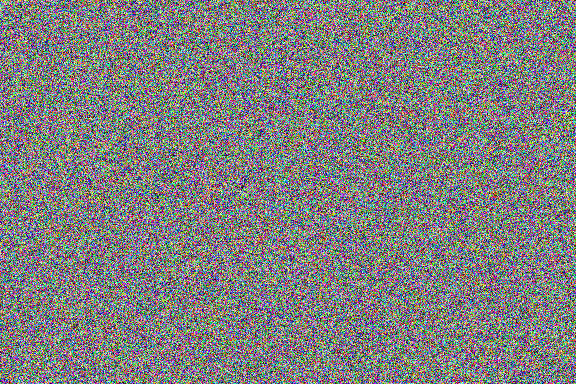

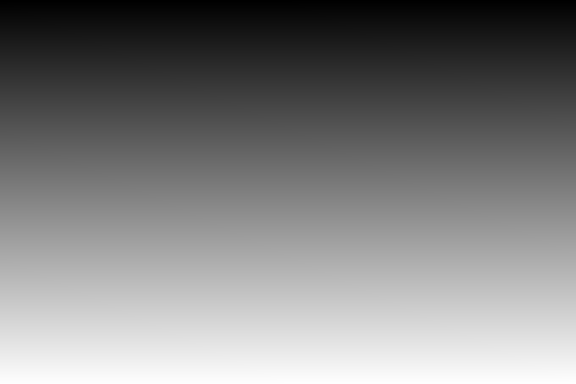

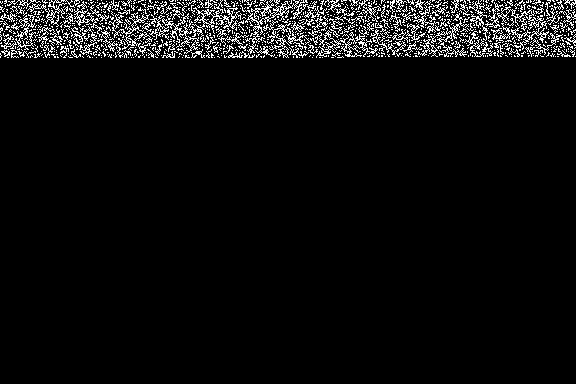

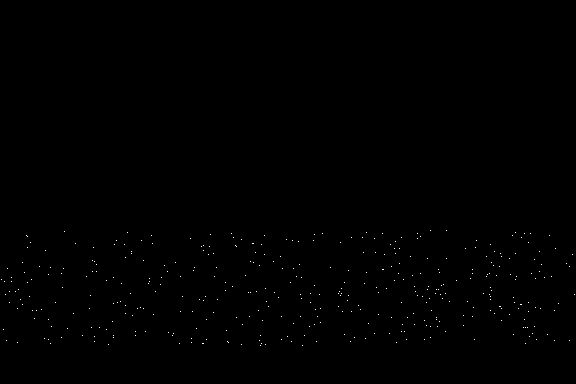

In [55]:
import numpy as np
from scipy.optimize import minimize
from depth_estimation_fns import overlay_color, display_mask_as_image
from PIL import Image

def find_farthest_points(d_D, percentage=15):
    # 15% of the points are farthest
    num_samples = d_D.shape[0]
    num_points = int(num_samples * (percentage) / 100)
    farthest_indices = np.argsort(d_D)[:num_points]
    return farthest_indices

def select_darkest_points(I, farthest_indices, percentage=20):
    # get darkest points from the farthest points per channel
    num_samples = len(farthest_indices)
    num_points = int(num_samples * percentage / 100)
    # get the darkest points from each channel
    darkest_indices = []
    for i in range(I.shape[0]):
        sorted_indices = farthest_indices[np.argsort(I[i, farthest_indices])]
        darkest_indices.append(sorted_indices[:num_points])
    return np.array(darkest_indices)

def compute_B_infty(I, darkest_indices):
    # Compute B_infty for each channel
    B_infty = np.zeros(I.shape[0])
    for i in range(I.shape[0]):
        B_infty[i] = np.median(I[i, darkest_indices[i]])
    return B_infty

def select_closest_points_within_range(d, percentage_range=(10, 40)):
    # Compute distance percentiles
    high_percentile = np.percentile(d, 100-percentage_range[0])
    low_percentile = np.percentile(d, 100-percentage_range[1])

    # Determine the range of indices within the percentile range
    within_range_indices = np.where((d >= low_percentile) & (d <= high_percentile))[0]

    return within_range_indices


def find_set_M(I, d, percentage_range=(10, 40), num_points=10):
    # Find indices within the specified range
    points_within_range = select_closest_points_within_range(d, percentage_range)
    # find the N darkest points within the range
    sorted_indices_G = np.argsort(I[0, points_within_range], axis=0)
    sorted_indices_B = np.argsort(I[1, points_within_range], axis=0)
    selected_indices_G = points_within_range[sorted_indices_G[:num_points]]
    selected_indices_B = points_within_range[sorted_indices_B[:num_points]]
    selected_indices = np.array([selected_indices_G, selected_indices_B])
    return selected_indices


def solve_optimisation_problem(d, I, initial_v=[1, 1], initial_mu=1, initial_B_infty=[1, 1], keep_B_infty=False):
    """
    Optimize parameters nu, mu, and B_infty for both G and B.

    Parameters:
    d: list
        List of distances
    I: list
        List of arrays for I_G and I_B.
    initial_v: list, optional
        Initial guess for the nu. Default is [1, 1].
    initial_mu: float, optional
        Initial guess for the mu. Default is 1.
    initial_B_infty: list, optional
        Initial guess for the B_infty. Default is [1, 1].

    Returns:
    hat_nu: numpy array
        Optimized values of nu for G and B.
    hat_mu: float
        Optimized value of mu.
    hat_B_infty: numpy array
        Optimized values of B_infty for G and B.
    """
    num_channels = I.shape[0]
    # Vectorized objective function
    def objective(params):
        nu = params[:num_channels]
        mu = params[num_channels]
        if keep_B_infty:
            B_infty = initial_B_infty
        else:
            B_infty = params[num_channels + 1:]
        # Calculate predicted values
        total_epsilon = np.sum(np.abs(I - B_infty[:, np.newaxis] * (1 - np.exp(-nu[:, np.newaxis] / (d + mu)))))
        return total_epsilon
    

    initial_guess = np.concatenate((initial_v, [initial_mu], initial_B_infty))
    result = minimize(objective, initial_guess, method='BFGS')
    hat_nu = result.x[:num_channels]
    hat_mu = result.x[num_channels]
    if keep_B_infty:
        hat_B_infty = initial_B_infty
    else:
        hat_B_infty = result.x[num_channels + 1:]
    return hat_nu, hat_mu, hat_B_infty

def find_underwater_parameters(d_D, I, N=10, M_range=(10, 40), initial_v=[1, 1], initial_mu=1, initial_B_infty=[1, 1], keep_B_infty=False):
    # Step 1: Find farthest 15% points
    farthest_indices = find_farthest_points(d_D)
    
    # Step 2: Select darkest 20% points per channel
    darkest_indices = select_darkest_points(I, farthest_indices)

    # Step 3: Compute B_infty for each channel
    if not keep_B_infty:
        initial_B_infty = compute_B_infty(I, darkest_indices)
    
    # Step 4: Select N darkest points from each channel
    M = find_set_M(I,d_D,percentage_range=M_range, num_points=N)
   # Select elements from I using indices in M
    I_new = []
    for i in range(len(M)):
        I_new.append(I[i, M[i]])
    I_new = np.array(I_new)

    # Step 5: Solve least-squares problem
    hat_nu, hat_mu, hat_B_infty = solve_optimisation_problem(d_D[M], I_new, initial_v=initial_v, initial_mu=initial_mu,
                                                             initial_B_infty=initial_B_infty, keep_B_infty=keep_B_infty)
    
    return hat_nu, hat_mu, hat_B_infty, darkest_indices, M
    

# Sample data
H = 576
W = 384
num_samples = H*W
n_channels = 3
# Generate d_D
d_D = np.arange(num_samples)
d_D = d_D / np.max(d_D)
print(d_D)
random_image = np.random.rand(W, H, n_channels)
I = random_image.reshape(n_channels, -1)[1:,:] # Remove the first channel
N_1 = 500
N_2 = 200
hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_1)
print("Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)




hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_2, initial_v=hat_nu, initial_mu=hat_mu, 
                                                         initial_B_infty=hat_B_infty, keep_B_infty=True)
                                                
print("2nd run Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)


random_image = (random_image*255).astype(np.uint8)
depth_image = (d_D*255).astype(np.uint8).reshape(W, H)

# create masks for the darkest points
darkest_mask = np.zeros(W*H, dtype=bool)
darkest_mask[darkest_indices] = True
darkest_mask = darkest_mask.reshape(W, H)
# create masks for  M set
M_mask = np.zeros(W*H, dtype=bool)
M_mask[M] = True
M_mask = M_mask.reshape(W, H)


display(Image.fromarray(random_image))
display(Image.fromarray(depth_image))
display_mask_as_image(darkest_mask)
display_mask_as_image(M_mask)

In [48]:
import numpy as np
import cv2 
from PIL import Image
import tifffile as tiff

from depth_estimation_fns import open_image, preprocess_image, predict_depth, post_process_depth, get_model_image_processor_pair, display_depth, default_image_dim, make_image_grid, return_mask_as_image

raw_image_path = "Datasets/SeaThru/D5/linearPNG/LFT_3402.png"
actual_depth_path = "Datasets/SeaThru/D5/depth/depthLFT_3402.tif"
model_name = "depth_anything"
model_path =  "nielsr/depth-anything-small"
device = "cuda"



model, image_processor = get_model_image_processor_pair(model_name, model_path, device)
raw_image, actual_depth = open_image(path=raw_image_path, depth_path=actual_depth_path, 
                                        result_ground_truth_image_path="Results/parameter_estimation_results/actual_depth.png", 
                                        img_dim=default_image_dim, save_ground_truth=False, display=False)
inputs = preprocess_image(image_processor=image_processor, image=raw_image)
predicted_depth = predict_depth(model=model, inputs=inputs)
model_output, formatted, depth_im = post_process_depth(depth=predicted_depth, image=raw_image, 
                                                       predicted_depth_path="Results/parameter_estimation_results/pred_depth.png", display=False)



Optimized Parameters:
hat_nu: [1.53592004e+02 1.32408886e-02]
hat_mu: 1.0
hat_B_infty: [ 0.01176476 10.56506997]
2nd run Optimized Parameters:
hat_nu: [1.53592004e+02 9.84848614e-03]
hat_mu: 1.0
hat_B_infty: [ 0.01176476 10.56506997]


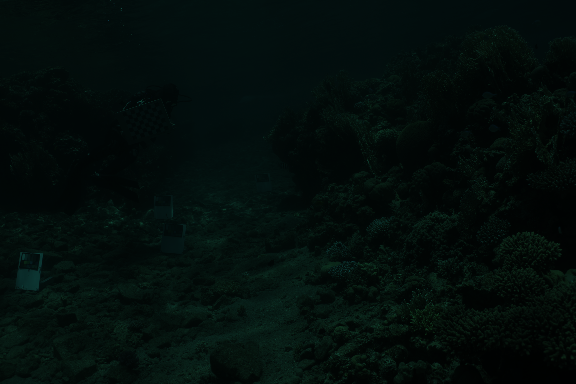

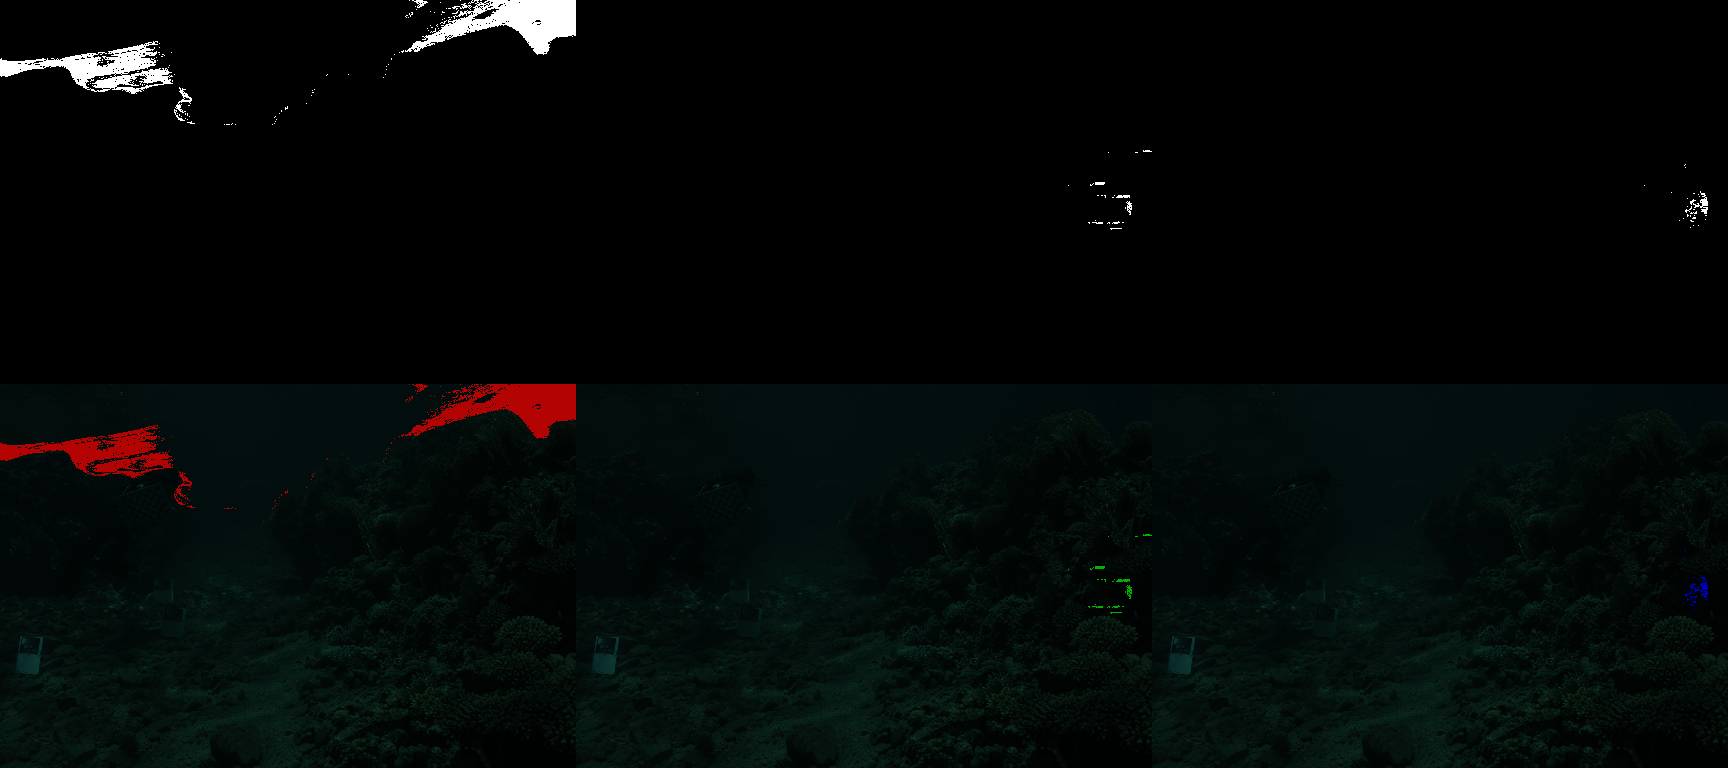

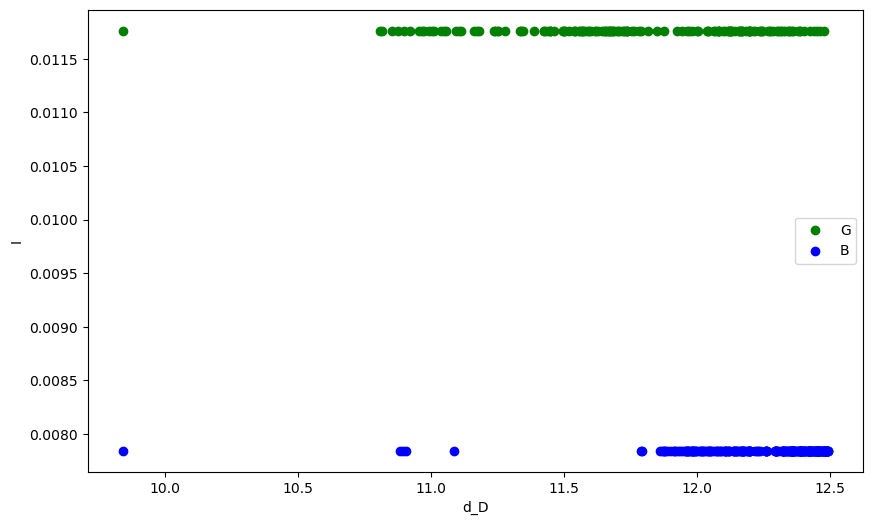

In [87]:
# plot I vs d_D plots on the same graph
import matplotlib.pyplot as plt
def produce_images_and_plots(W,H, raw_image, d_D, I, darkest_indices, M):

    # create masks for the darkest points
    darkest_mask = np.zeros(W*H, dtype=bool)
    darkest_mask[darkest_indices] = True
    darkest_mask = darkest_mask.reshape(W, H)
    # create masks for  M set
    M_mask_green = np.zeros(W*H, dtype=bool)
    M_mask_green[M[0,:]] = True
    M_mask_green = M_mask_green.reshape(W, H)
    M_mask_blue = np.zeros(W*H, dtype=bool)
    M_mask_blue[M[1,:]] = True
    M_mask_blue = M_mask_blue.reshape(W, H)

    display(raw_image)
    masks = [darkest_mask, M_mask_green, M_mask_blue]
    mask_colors = [(1,0,0), (0,1,0), (0,0,1)]
    mask_images = [return_mask_as_image(mask) for mask in masks]
    applied_masks = [Image.fromarray(overlay_color(np.array(raw_image), mask=mask, color=color, alpha=0.7)) for mask, color in zip(masks, mask_colors)]
    all_images = mask_images + applied_masks
    display(make_image_grid(all_images, rows=2, cols=3))

    plt.figure(figsize=(10, 6))
    plt.scatter(d_D[M[0]], I[0, M[0]], c='g', label='G')
    plt.scatter(d_D[M[1]], I[1, M[1]], c='b', label='B')
    plt.xlabel('d_D')
    plt.ylabel('I')
    plt.legend()
    plt.show()

N_1 = 500
N_2 = 200
# get G,B from raw_image
I  = np.array([np.array(raw_image.getchannel('G')).flatten(), np.array(raw_image.getchannel('B')).flatten()])/255.0

d_D = model_output.flatten()
hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_1)
print("Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)

# produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, darkest_indices, M)

hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_2, initial_v=hat_nu, initial_mu=hat_mu, 
                                                         initial_B_infty=hat_B_infty, keep_B_infty=True)
                                                
print("2nd run Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)

produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, darkest_indices, M)


# img = np.array(raw_image)
# display(Image.fromarray(overlay_color(np.array(raw_image), mask=darkest_mask, color=(0, 0, 1), alpha=0.5)))
# overlay_color(img, mask=M_mask_blue, color=(0,0,1), alpha=0.5)
# display(Image.fromarray(overlay_color(img, mask=M_mask_green, color=(0,1, 0), alpha=1)))


In [88]:
import numpy as np

def get_medium_transmission_vectorized(d_D, nu, mu):
    """
    Compute medium transmission for each channel across all samples using vectorized operations.

    Parameters:
        d_D (numpy.ndarray): Array of size (samples,) containing depth values.
        nu (numpy.ndarray): Array of size (channels,) containing nu values.
        mu (float): Scalar value of mu.

    Returns:
        numpy.ndarray: Array of size (channels, samples) containing medium transmission for each channel.
    """
    # Expand dimensions of nu to match the shape of d_D
    nu_expanded = np.expand_dims(nu, axis=1)  # Shape: (channels, 1)

    # Compute medium transmission for each channel across all samples using vectorized operations
    medium_transmission = np.exp(-nu_expanded / (d_D + mu))

    return medium_transmission


t_hat = get_medium_transmission_vectorized(d_D, hat_nu, hat_mu)

L_bl1: 0.0017228375077411654, L_bl2: 0.04131796425543868, L_bu: 0.003815183193790903
lb: 0.050671168150761656


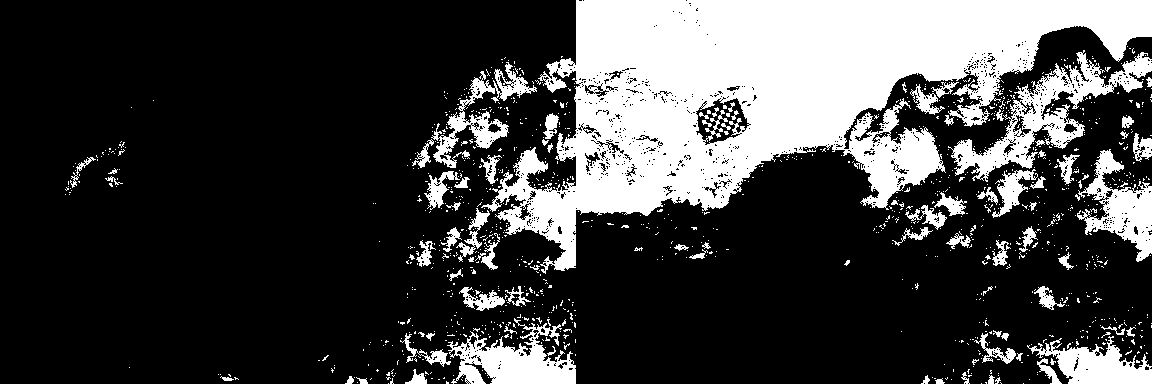

In [155]:
import numpy as np
def compute_lb_loss(I, t_hat, B_infty):
    """
    Compute lower loss function

    Parameters:
        I (numpy.ndarray): Input image array of shape (channels, HW).
        t_hat (numpy.ndarray): Predicted medium transmission array of shape (channels, HW).
        B_infty (numpy.ndarray): Predicted background light array of shape (channels,).

    Returns:
        tuple: numpy.ndarray containing the loss values
    """
    # Compute the intermediate expressions
    intermediate_bl1 = -I + (1 - t_hat) * B_infty[:, np.newaxis]
    intermediate_bl2 = -t_hat - intermediate_bl1

    loss_bl1 = np.sum(np.maximum(intermediate_bl1, 0))/I.shape[1]
    loss_bl2 = np.sum(np.maximum(intermediate_bl2, 0))/I.shape[1]
    
    return loss_bl1, loss_bl2

def compute_lu_loss(I, t_hat_D, t_hat_P, B_infty):
    """
    Compute loss function.

    Parameters:
        I (List[numpy.ndarray]): Input image array of shape (channels, npoints).
        t_hat (List[numpy.ndarray]): Predicted medium transmission array of shape (channels, npoints).
        B_infty (numpy.ndarray): Predicted background light array of shape (channels,).

    Returns:
        tuple: the loss value
    """
    # Compute the intermediate expressions
    loss_lu = 0
    for c in range(len(I)):
        intermediate_lu = - (1-t_hat_P[c]) * B_infty[c] - t_hat_D[c] + I[c]
        loss_lu += np.sum(np.maximum(intermediate_lu, 0))/I[c].shape[0]

    return loss_lu

def find_M_b(I, B_infty_hat, t_hat_D, gamma=0.6):
    """
    Find set M_b based on the given condition.

    Parameters:
        I (numpy.ndarray): Input image array of shape (channels, samples).
        B_infty_hat (numpy.ndarray): Predicted background light array of shape (channels,).
        t_hat_D (numpy.ndarray): Predicted dehazed medium transmission array of shape (channels, samples).
        gamma (float): Threshold hyperparameter.

    Returns:
        numpy.ndarray: Boolean array indicating the set M_b.
    """
    # Compute the expression (B_infty_hat * (1 - t_hat_D)) / I
    expression = (B_infty_hat[:, np.newaxis] * (1 - t_hat_D)) / I

    # Find indices where the expression is greater than or equal to gamma
    M_b_indices = expression >= gamma
    return M_b_indices

def compute_loss_bounds(I, t_hat_P, t_hat_D, B_infty, alphas=[1,1,2], show_MB=False, default_image_dim=(384, 576)):
    """
    Compute bound loss

    Parameters:
        I (numpy.ndarray): Input image array of shape (channels, HW).
        t_hat_P (numpy.ndarray): PuDE Predicted medium transmission array of shape (channels, HW).
        t_hat_D (numpy.ndarray): DPT Predicted medium transmission array of shape (channels, HW).
        B_infty (numpy.ndarray): Predicted background light array of shape (channels,).

    Returns:
        tuple:  the loss values
    """
    
    loss_bl1, loss_bl2 = compute_lb_loss(I, t_hat_P, hat_B_infty)
    M_mask = find_M_b(I, hat_B_infty, t_hat_D)
    I_new = [I[0, M_mask[0]], I[1, M_mask[1]]]
    t_hat_P_new = [t_hat_P[0, M_mask[0]], t_hat_P[1, M_mask[1]]]
    t_hat_D_new = [t_hat_D[0, M_mask[0]], t_hat_D[1, M_mask[1]]]
    loss_bu= compute_lu_loss(I_new, t_hat_D_new, t_hat_P_new, hat_B_infty)

    lb = alphas[0]*loss_bl1 + alphas[1]*loss_bl2 + alphas[2]*loss_bu

    
    if show_MB:
        print(f"L_bl1: {loss_bl1}, L_bl2: {loss_bl2}, L_bu: {loss_bu}")
        print(f"lb: {lb}")
        # print(loss_bl1, loss_bl2, loss_bu)
        images = []
        for i in range(2):
            images.append(return_mask_as_image(M_mask[i].reshape(default_image_dim[1], default_image_dim[0])))
        display(make_image_grid(images, rows=1, cols=2))
    return lb



lb = compute_loss_bounds(I, t_hat, t_hat, hat_B_infty, show_MB=True, default_image_dim=default_image_dim)
